# Fit models for strong enhancer vs. silencer
This notebook fits various models to classify strong enhancers vs. silencers with 5-fold cross-validation. Fit 6-mer SVMs or logistic regression models on CRX occupancy, TF occupancies, and information content (entropy). Process the White 2013 data and use as a test set. Then fit logistic regression models using random TFs (100 times) to generate a background distribution. Also fit an information content logistic regression model for strong enhancer vs. inactive.

Note that fitting the background distribution takes approximately 50 minutes on a single Intel Core i7 CPU with 3.9 GHz and 16 GB of RAM.

In [1]:
import os
import sys
import pickle

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from IPython.display import display

sys.path.insert(0, "utils")
from utils import fasta_seq_parse_manip, gkmsvm, modeling, plot_utils, predicted_occupancy, sequence_annotation_processing

data_dir = os.path.join("Data")
seq_bins_dir = os.path.join(data_dir, "ActivityBins")
models_dir = os.path.join("Models")
figures_dir = os.path.join("Figures")
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))
# Drop scrambled sequences
all_seqs = all_seqs[~(all_seqs.index.str.contains("scr"))]

In [2]:
plot_utils.set_manuscript_params()

## Read in data and prepare for modeling

In [3]:
activity_df = pd.read_csv(os.path.join(data_dir, "wildtypeMutantPolylinkerActivityAnnotated.txt"), sep="\t", index_col=0)
# Drop sequences where the WT group is NaN from analysis
activity_df = activity_df[activity_df["group_name_WT"].notna()]
activity_df["group_name_WT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_WT"])
activity_df["group_name_MUT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_MUT"])

# Read in occupancies
occupancy_df = pd.read_csv(os.path.join(data_dir, "predictedOccupancies.txt"), sep="\t", index_col=0)
# Only keep WT with an annotated class
wt_occupancy_df = occupancy_df[occupancy_df.index.str.contains("WT$")].copy()
wt_occupancy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_occupancy_df)
wt_occupancy_df = wt_occupancy_df.loc[activity_df.index]

# Same idea for information contents
entropy_df = pd.read_csv(os.path.join(data_dir, "entropyDiversityOccupancy.txt"), sep="\t", index_col=0)
wt_entropy_df = entropy_df[entropy_df.index.str.contains("WT$")].copy()
wt_entropy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_entropy_df)
wt_entropy_df = wt_entropy_df.loc[activity_df.index]

# Mask to pull out the silencers and strong enhancers
silencer_modeling_mask = activity_df["group_name_WT"].str.contains("Strong|Silencer")
# Mask to pull out the inactive seqs and the strong enhancers
inactive_modeling_mask = activity_df["group_name_WT"].str.contains("Strong|Inactive")

# Within the data to model, mask indicating which sequences are strong enhancers
labels_with_silencer = activity_df.loc[silencer_modeling_mask, "group_name_WT"].str.contains("Strong")
labels_with_inactive = activity_df.loc[inactive_modeling_mask, "group_name_WT"].str.contains("Strong")

# Sequences file for the SVM
positives_fasta = os.path.join(seq_bins_dir, "strongEnhancer.fasta")
negatives_fasta = os.path.join(seq_bins_dir, "silencer.fasta")

# Read in PWMs for the test set
pwms = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorAndEnrichedMotifs.meme"))
ewms = pwms.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)
mu = 9

## Fit k-mer SVM to the data

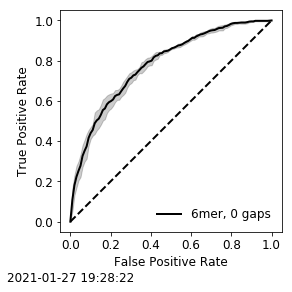

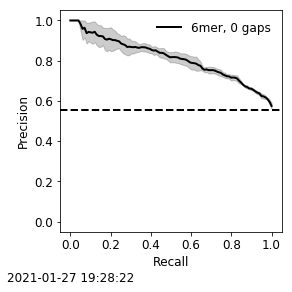

In [4]:
# Hyperparameter setup
seed = 1210
word_len = 6
max_mis = 1
nfolds = 5

svm_dir = os.path.join(models_dir, "StrongEnhancerVsSilencer")
if not os.path.exists(svm_dir):
    os.makedirs(svm_dir)

# Fit the SVM
svm_prefix = os.path.join(svm_dir, f"gkmsvm_{word_len}_{word_len}_{max_mis}")
fig_list, xaxis, svm_tpr, svm_prec, svm_f1 = gkmsvm.train_with_cv(positives_fasta, negatives_fasta, svm_prefix, num_folds=nfolds, word_len=word_len, info_pos=word_len, max_mis=max_mis, seed=seed)
# Score k-mers for motif analysis
kmer_scores = gkmsvm.score_all_kmers(word_len, word_len, max_mis, svm_prefix, os.path.join(svm_dir, f"all{word_len}mers"))
# Flip the sign for the scores to generate PWMs for the negatives too
kmer_scores = -kmer_scores
kmer_scores.to_csv(os.path.join(svm_dir, f"all{word_len}mersPredNeg.out"), sep="\t", header=False)

## Fit logistic regression model using CRX occupancy, TF occupancies, and entropy
For the TF occupancies, do grid search for the regularization hyperparameter (`C`) since there are multiple features. For the other models, there is only one feature.

In [5]:
cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=seed)
# CRX occupancy
crx_clf = LogisticRegression()
crx_clf, crx_tpr_list, crx_prec_list, crx_f1_list = modeling.train_estimate_variance(crx_clf, cv, wt_occupancy_df.loc[silencer_modeling_mask, "CRX"], labels_with_silencer, xaxis, positive_cutoff=0)

# Information content
entropy_clf = LogisticRegression()
entropy_clf, entropy_tpr_list, entropy_prec_list, entropy_f1_list = modeling.train_estimate_variance(entropy_clf, cv, wt_entropy_df.loc[silencer_modeling_mask, "entropy"], labels_with_silencer, xaxis, positive_cutoff=0)

# 8 TF occupancies
occ_clf = LogisticRegression()
param_grid = {"C": np.logspace(-4, 4, 9)}
np.random.seed(seed)
occ_clf, occ_tpr_list, occ_prec_list = modeling.grid_search_hyperparams(occ_clf, nfolds, param_grid, "f1", wt_occupancy_df[silencer_modeling_mask], labels_with_silencer, xaxis, positive_cutoff=0)
c_opt = occ_clf.get_params()["C"]
print(f"Optimal regularization strength (C): {c_opt:1.1e}")

# Save the 8 TF occupancy regressor to file
pickle.dump(occ_clf, open(os.path.join(svm_dir, "logit_model.pkl"), "wb"))

Optimal regularization strength (C): 1.0e-02


## Write cross-validated model performances to file

In [6]:
# Helper function
def write_folds(data, filename, out_dir=svm_dir):
    pd.DataFrame(data).to_csv(os.path.join(out_dir, filename), sep="\t", index=False, header=False)

write_folds(svm_tpr, "svmTprCv.txt")
write_folds(svm_prec, "svmPrecCv.txt")
write_folds(crx_tpr_list, "crxTprCv.txt")
write_folds(crx_prec_list, "crxPrecCv.txt")
write_folds(entropy_tpr_list, "entropyTprCv.txt")
write_folds(entropy_prec_list, "entropyPrecCv.txt")
write_folds(occ_tpr_list, "occupancyTprCv.txt")
write_folds(occ_prec_list, "occupancyPrecCv.txt")

## Fit strong enhancer vs. inactive logistic model for information content

In [8]:
inactive_dir = os.path.join(models_dir, "StrongEnhancerVsInactive")
if not os.path.exists(inactive_dir):
    os.makedirs(inactive_dir)

inactive_entropy_clf = LogisticRegression()
inactive_entropy_clf, inactive_entropy_tpr_list, inactive_entropy_prec_list, inactive_entropy_f1_list = modeling.train_estimate_variance(inactive_entropy_clf, cv, wt_entropy_df.loc[inactive_modeling_mask, "entropy"], labels_with_inactive, xaxis, positive_cutoff=0)
write_folds(inactive_entropy_tpr_list, "entropyTprCv.txt", out_dir=inactive_dir)
write_folds(inactive_entropy_prec_list, "entropyPrecCv.txt", out_dir=inactive_dir)

## Use of the White 2013 data as a test set
For now, just use a test set for the SVM and TF occupancies.

### Read in the sequences (Dataset S1) and format appropriately

In [9]:
white_data_dir = os.path.join("Data", "Downloaded", "CrxMpraLibraries")
white_seqs = pd.read_csv(os.path.join(white_data_dir, "white2013Sequences.txt"), sep="\t", header=None, usecols=[0, 8], index_col=0, squeeze=True, names=["label", "sequence"])
# Only keep barcode1 sequences since barcode info isn't needed
bc_tag = "_barcode1"
white_seqs = white_seqs[white_seqs.index.str.contains(bc_tag)]
# Trim off the barcode ID
white_seqs = white_seqs.rename(lambda x: x[1:-len(bc_tag)])
# Only keep the 84 bp of the sequence that corresponds to the library
seq_len = 84
seq_start = len("TAGCGTCTGTCCGTGAATTC") + 1
white_seqs = white_seqs.str[seq_start:seq_start+seq_len]

### Read in the data (Dataset S2) and compute predicted occupancies

In [10]:
# Function to correct off by one error in labeling
def correct_label(name):
    chrom, pos, group = name.split("_")
    pos = int(pos) + 1
    return "_".join([chrom, str(pos), group])

white_activity_df = pd.read_csv(os.path.join(white_data_dir, "white2013Activity.txt"), sep="\t", index_col=0, usecols=[0, 1, 2, 3], names=["label", "class", "expression", "expression_SEM"], header=0)
# Correct the off by one error of the labels
white_activity_df = white_activity_df.rename(correct_label)
white_activity_df["expression_log2"] = np.log2(white_activity_df["expression"])

white_measured_seqs = white_seqs[white_activity_df.index]
white_occupancy_df = predicted_occupancy.all_seq_total_occupancy(white_measured_seqs, ewms, mu, convert_ewm=False)
white_occupancy_df = white_occupancy_df.rename(columns=lambda x: x.split("_")[0])
white_entropy_df = white_occupancy_df.apply(predicted_occupancy.boltzmann_entropy, axis=1)

### Define strong enhancers and inactive sequences based on scrambled sequences
Only do this for bound sequences. Strong enhancers are above the 95th percentile of scrambled, inactive sequences are the 15% centered around the mean of scrambled, silencers are anything that is at least 2 fold below the mean of scrambled.

In [11]:
# Define cutoffs
scrambled_mask = white_activity_df["class"].str.contains("SCR")
strong_cutoff = white_activity_df.loc[scrambled_mask, "expression_log2"].quantile(0.95)
white_scrambled_mean = white_activity_df.loc[scrambled_mask, "expression_log2"].mean()

# Inactive (not used)
# inactive_middle = stats.percentileofscore(bound_activity_df["expression_log2"], white_scrambled_mean) / 100
# inactive_percentile_width = 0.15

# Pull out bound sequences
bound_mask = white_activity_df["class"].str.match("CBR(M|NO)$")
bound_activity_df = white_activity_df[bound_mask].copy()
bound_occupancy_df = white_occupancy_df[bound_mask]
bound_entropy_df = white_entropy_df[bound_mask]

# Pull out relevant sequences
white_strong_mask = bound_activity_df["expression_log2"] > strong_cutoff
white_silencer_mask = bound_activity_df["expression_log2"] < (white_scrambled_mean - 1)
white_modeling_mask = white_strong_mask | white_silencer_mask
white_labels = white_strong_mask[white_modeling_mask]

### Make predictions with the SVM and the occupancy logistic model

In [12]:
# Write sequences to file for the SVM
white_modeling_seqs = white_seqs[bound_activity_df.index][white_modeling_mask]
white_modeling_fasta = os.path.join(svm_dir, "white2013TestSet.fasta")
fasta_seq_parse_manip.write_fasta(white_modeling_seqs, white_modeling_fasta)

# SVM
svm_white_tpr, svm_white_prec, svm_white_scores, svm_white_f1 = gkmsvm.predict_and_eval(white_modeling_fasta, white_labels, svm_prefix, word_len, word_len, max_mis, xaxis)
write_folds(svm_white_tpr, "whiteSvmTpr.txt")
write_folds(svm_white_prec, "whiteSvmPrec.txt")

# Logistic model
occupancy_probs = occ_clf.predict_proba(bound_occupancy_df[white_modeling_mask])
occupancy_white_tpr, occupancy_white_prec, occupancy_white_f1 = modeling.calc_tpr_precision_fbeta(white_labels, occupancy_probs[:, 1], xaxis, positive_cutoff=0.5)
write_folds(occupancy_white_tpr, "whiteOccTpr.txt")
write_folds(occupancy_white_prec, "whiteOccPrec.txt")

## Assess TF occupancy feature robustness
Do this by fitting strong enhancer vs. silencer logistic regression models using the predicted occupancies of random TFs from the HOCOMOCO database. Do this 100 times to generate a background distribution.

### Read in database and convert to EWMs

In [13]:
hocomoco = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorMotifsAndHOCOMOCOv11_full_MOUSE.meme"))
hocomoco = hocomoco.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)

### Fit model with random PWMs

In [14]:
wt_seqs = all_seqs[all_seqs.index.str.contains("WT")].copy()
wt_seqs = sequence_annotation_processing.remove_mutations_from_seq_id(wt_seqs)
wt_seqs = wt_seqs[activity_df.index]
modeling_seqs = wt_seqs[silencer_modeling_mask]

niter = 100
nfeatures = len(ewms)
# Track the cross-validated mean TPR and precision for each feature set
random_tprs = []
random_precs = []
# Keep track of the features selected for each round
random_ewms = []

np.random.seed(seed)
for i in range(niter):
    if i % 10 == 9:
        print(f"Iteration {i+1}")
        
    # Randomly sample PWMs
    sample = hocomoco.sample(nfeatures)
    random_ewms.append(sample.index.str.split("_").str[0].values)
    # Do predicted occupancy scan
    features = predicted_occupancy.all_seq_total_occupancy(modeling_seqs, sample, mu, convert_ewm=False)
    # Fit the model
    clf = LogisticRegression(C=c_opt)
    clf, tpr, prec, f1 = modeling.train_estimate_variance(clf, cv, features, labels_with_silencer, xaxis, positive_cutoff=0)
    
    # Store the result
    random_tprs.append(np.mean(tpr, axis=0))
    random_precs.append(np.mean(prec, axis=0))

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100


In [15]:
# Save results to file
write_folds(random_tprs, "randomFeaturesMeanTprs.txt")
write_folds(random_precs, "randomFeaturesMeanPrecs.txt")
write_folds(random_ewms, "randomFeaturesList.txt")